# Convuntional Neural Network

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='.../Data',train=True,download=True,transform=transform)

In [7]:
test_data = datasets.MNIST(root='.../Data',train=False,download=True,transform=transform)

In [8]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [16]:
# COLOR CHANNEL, 6 FILTERS (OUTPUT CHANNELS), 3by3 KERNEL,STRIDE=1
conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)

# INPUT FILTERS 6, 16 FILTERS (OUTPUT CHANNELS), 3by3 KERNEL,STRIDE=1
conv2 = nn.Conv2d(6,16,3,1)

In [39]:
for i, (X_train,y_train) in enumerate(train_data):
    break

In [40]:
X_train.shape

torch.Size([1, 28, 28])

In [41]:
x = X_train.view(1,1,28,28)

In [42]:
x = F.relu(conv1(x))

In [43]:
x.shape

torch.Size([1, 6, 26, 26])

In [44]:
x = F.max_pool2d(x,2,2)

In [45]:
x.shape

torch.Size([1, 6, 13, 13])

In [46]:
x = F.relu(conv2(x))

In [47]:
x.shape

torch.Size([1, 16, 11, 11])

In [48]:
x = F.max_pool2d(x,2,2)

In [49]:
x.shape

torch.Size([1, 16, 5, 5])

In [50]:
x = x.view(-1, 5*5*16)

In [51]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)  # 5*5 --> x.shape and 120 arbitrary choice 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [52]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [54]:
for param in model.parameters() :
    print(param.numel())    # number of parameters

54
6
864
16
48000
120
10080
84
840
10


In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [85]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%3000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \ accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    

end_time = time.time()
total = end_time - start_time
print(f'Training Took {int(total/60)} minutes et {total%60} secondes')

epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00010584  ccuracy:  99.780%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00000383  ccuracy:  99.768%
epoch:  1  batch: 3000 [ 30000/60000]  loss: 0.00000000  ccuracy:  99.787%
epoch:  1  batch: 6000 [ 60000/60000]  loss: 0.00000000  ccuracy:  99.752%
epoch:  2  batch: 3000 [ 30000/60000]  loss: 0.00541049  ccuracy:  99.807%
epoch:  2  batch: 6000 [ 60000/60000]  loss: 0.00000000  ccuracy:  99.772%
epoch:  3  batch: 3000 [ 30000/60000]  loss: 0.00000010  ccuracy:  99.807%
epoch:  3  batch: 6000 [ 60000/60000]  loss: 0.00012079  ccuracy:  99.813%
epoch:  4  batch: 3000 [ 30000/60000]  loss: 0.00000002  ccuracy:  99.820%
epoch:  4  batch: 6000 [ 60000/60000]  loss: 0.00000000  ccuracy:  99.827%
epoch:  5  batch: 3000 [ 30000/60000]  loss: 0.00000234  ccuracy:  99.813%
epoch:  5  batch: 6000 [ 60000/60000]  loss: 0.00001146  ccuracy:  99.773%
epoch:  6  batch: 3000 [ 30000/60000]  loss: 0.00000008  ccuracy:  99.870%
epoch:  6  b

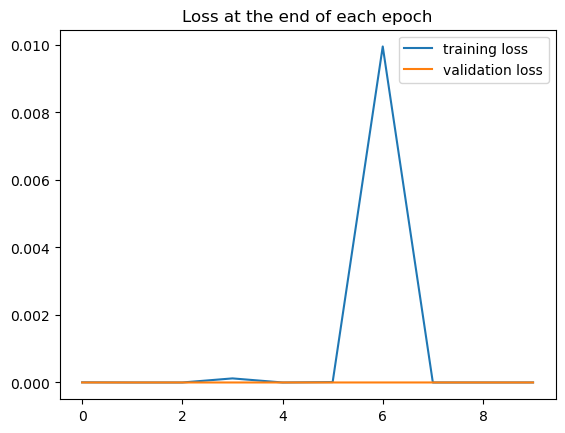

In [86]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

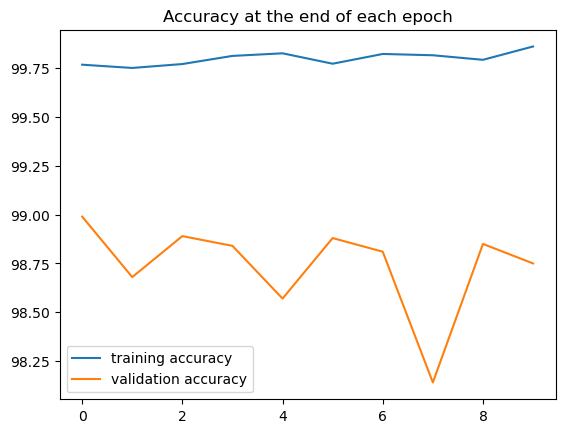

In [87]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [88]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [89]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9875/10000 =  98.750%


In [90]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 978    0    3    0    0    1    5    1    6    0]
 [   0 1131    1    0    0    0    1    2    0    0]
 [   0    0 1014    2    0    0    0    3    1    0]
 [   0    1    2 1002    0   17    0    2    2    2]
 [   0    0    1    0  975    0    1    0    0    7]
 [   0    1    0    3    0  870    1    0    2    2]
 [   1    0    0    0    4    1  948    0    2    0]
 [   0    1    6    1    0    1    0 1012    1    4]
 [   0    1    5    2    0    1    2    1  951    0]
 [   1    0    0    0    3    1    0    7    9  994]]


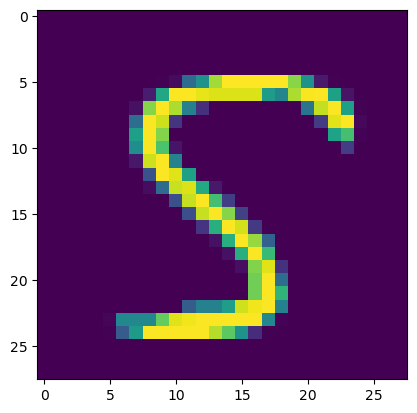

In [95]:
plt.imshow(test_data[333][0].reshape(28,28))

In [96]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[333][0].view(1,1,28,28))
    

In [97]:
new_prediction.argmax()

tensor(5)